# Forecasting using causal inference for variable selection


In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     

import xarray as xr
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr
from tigramite.models import Prediction

/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/../versions.py'
  warnings.warn(str(e))
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: [Errno 2] No such file or directory: '/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/../../versions.py'
  warnings.warn(str(e))
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'gpytorch'
  warnings.warn(str(e))
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/models.py:29: UserWarning: [Errno 2] No such file or directory: '/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/../versio

## Analysis Parameters


<!-- CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Daily.nc

CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Monthly.nc -->

<!-- Tumbarumba/2022_v1/L6/default/Tumbarumba_L6_20020107_20191231_Daily.nc

'AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Daily.nc'

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Monthly.nc

'Tumbarumba/2022_v1/L6/default/Tumbarumba_L6_20020107_20191231_Monthly.nc'

/Gingin/2022_v1/L6/default/Gingin_L6_20111013_20201231_Monthly.nc

Gingin/2022_v1/L6/default/Gingin_L6_20111013_20201231_Daily.nc

CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Monthly.nc

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Monthly.nc

Whroo/2022_v1/L6/default/Whroo_L6_20111201_20220218_Monthly.nc

Whroo/2022_v1/L6/default/Whroo_L6_20111201_20220218_Daily.nc

DryRiver/2022_v1/L6/default/DryRiver_L6_20091025_20220218_Monthly.nc

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Daily.nc

GreatWesternWoodlands/2022_v1/L6/default/GreatWesternWoodlands_L6_20130101_20220101_Daily.nc

GreatWesternWoodlands/2022_v1/L6/default/GreatWesternWoodlands_L6_20130101_20220101_Monthly.nc 

In [2]:
site = 'Gingin/2022_v1/L6/default/Gingin_L6_20111013_20201231_Monthly.nc'
var = ['NEE_SOLO', 'Ta', 'VPD','Precip', 'Fsd']
var_names = ['NEE','Ta', 'VPD', 'precip', 'solar']
target = 0 #GPP
tau_max = 1
steps_ahead = 1
model_type = RandomForestRegressor()

## Load data

In [3]:
def VPD(rh, ta):
    sat_vp = (6.11 * np.exp((2500000/461) * (1/273 - 1/(273 + ta))))
    vpd = (((100 - rh)/100) * sat_vp)
    return vpd

ds = xr.open_dataset('https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/'+site)
# ds = ds.sel(time=slice(time[0], time[1]))
ds['GPP_SOLO'] = xr.where(ds.GPP_SOLO < 0, 0, ds.GPP_SOLO)  #Set negative GPP, ER, and ET measurements as zero
ds['ER_SOLO'] = xr.where(ds.ER_SOLO < 0, 0, ds.ER_SOLO)  #Set negative GPP, ER, and ET measurements as zero
ds['ET'] = xr.where(ds.ET < 0, 0, ds.ET)  #Set negative GPP, ER, and ET measurements as zero
ds['VPD'] = VPD(ds.RH, ds.Ta)

ds_clim_mean = ds.groupby('time.month').mean()
ds = (ds.groupby('time.month') - ds_clim_mean)

df = ds.to_dataframe().reset_index(
        level=[1, 2]).drop(['latitude', 'longitude'], axis=1)

# calculate VPD on ec data
#df['VPD'] = VPD(df.RH, df.Ta)
df = df[var].dropna()
# test = df[-6:]
# df = df[0:-6]

data = df.values
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
dataframe = pp.DataFrame(data, 
                         datatime = {0:np.arange(len(data))}, 
                         var_names=var_names)

# # Initialize dataframe object, specify time axis and variable names
# test_dataframe = pp.DataFrame(test.values, 
#                          datatime = {0:np.arange(len(test.values))}, 
#                          var_names=var_names)

## Prediction with Tigramite

Tigramite also contains a class tigramite.models.Prediction to perform predictions based on the sklearn models. The Prediction class includes a wrapper around run_pc_stable from the PCMCI class to perform predictor selection

We initialize the Prediction class with cond_ind_model=ParCorr(). Secondly, we choose sklearn.linear_model.LinearRegression() here for prediction. Last, we scale the data via data_transform. The class takes care of rescaling the data for prediction. The parameters train_indices and test_indices are used to divide the data up into a training set and test set. The test set is optional since new data can be supplied later. The training set is used to select predictors and fit the model.

In [4]:
# tp.plot_timeseries(dataframe, figsize=(15, 5))

In [5]:
pred = Prediction(dataframe=dataframe,
        cond_ind_test=ParCorr(), 
        prediction_model=model_type,
        # data_transform=sklearn.preprocessing.StandardScaler(),
        train_indices= range(int(0.8*T)),
        test_indices= range(int(0.8*T), T),
        verbosity=1
    )


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
selected_links = {0: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 1: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 2: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 3: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 4: []}
independence test = par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable NEE has 3 link(s):
    [pc_alpha = 0.4]
        (NEE -1): max_pval = 0.00000, min_val =  0.571
        (precip -1): max_pval = 0.12074, min_val = -0.150
        (Ta -1): max_pval = 0.32919, min_val = -0.095

    Variable Ta has 2 link(s):
    [pc_alpha = 0.2]
        (Ta -1): max_pval = 0.00036, min_val =  0.339
        (precip -1): max_pval = 0.1569

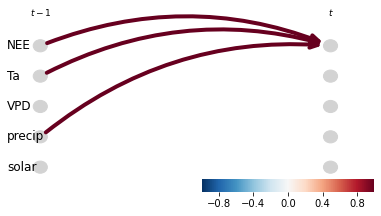

In [6]:
# Make solar have no parents
selected_links = {}

for j in range(N):
    if j in list(range(N-1)):
        selected_links[j] = [(var, -lag) for var in range(N)
                         for lag in range(0, tau_max + 1)]
    else:
        selected_links[j] = []

predictors = pred.get_predictors(
                  selected_targets=[target],
                  steps_ahead=steps_ahead,
                  tau_max=tau_max,
                  pc_alpha=None,
                  selected_links=selected_links
                  )

graph = np.zeros((N, N, tau_max+1), dtype='bool')

for j in [target]:
    for p in predictors[j]:
        graph[p[0], j, abs(p[1])] = 1

# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
#     node_aspect=2.,
    val_matrix=np.ones(graph.shape),
    graph=graph,
    var_names=var_names,
    link_colorbar_label='',
    );

In [7]:
pred.fit(target_predictors=predictors, 
         selected_targets=[target],
         tau_max=tau_max
        )


##
## Predicting target 0
##


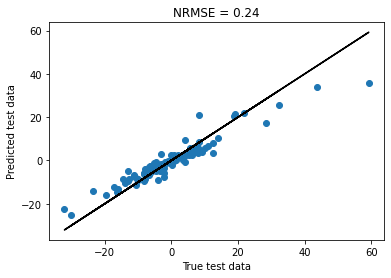

In [8]:
predicted = pred.predict(target)
true_data = pred.get_test_array()[0]

plt.scatter(true_data, predicted)
plt.title(r"NRMSE = %.2f" % (np.abs(true_data - predicted).mean()/true_data.std()))
plt.plot(true_data, true_data, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')
plt.show()

## Multivariate forecasting using vector autoregression with causally selected variables

In [9]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tools.eval_measures import rmse

forecast_length = steps_ahead
pred_var = df.columns[target]

### Set up dataframe, selecting only variables causally related

In [10]:
gpp_predictors = predictors.get(target)
results = []
for i in gpp_predictors:
    print(i)
    col = df.columns[i[0]]
    series = df[col]
    results.append(series)

df_in = pd.concat(results, axis=1)
df_in.head(3)

(0, -1)
(3, -1)
(1, -1)


,NEE_SOLO,Precip,Ta
time,,,
2011-11-01 00:30:00,16.087954,11.820000,-0.520767
2011-12-01 00:30:00,5.611817,-8.900000,0.705277
2012-01-01 00:30:00,0.731140,-21.666667,2.180784


### Fit model using the significant lag

In [11]:
lag_order = np.abs(gpp_predictors[0][1])

model=VAR(df_in, freq='MS')
model_fit = model.fit(lag_order)

### Iteratively backtest

In [12]:
n_windows = int((len(df_in) / forecast_length) - 1)
window_size = forecast_length

aa = window_size
dfs=[]
for i in range(0, n_windows):
    start=aa+lag_order
    end=(aa)
    backtest_input = df_in.values[-start:-end] 
    fc = model_fit.forecast(y=backtest_input, steps=window_size)  
    if i == 0:
        index=df_in.index[-end:]
    else:
        index=df_in.index[-end:-(end-window_size)]
    fc = pd.DataFrame(fc, index=index, columns=df_in.columns)
    dfs.append(fc)
    aa+=window_size                       

#concat results together
fc=pd.concat(dfs)

In [13]:
test=df_in[df_in.index.isin(fc.index)]
for i in test.columns:
    print('rmse value for', i, 'is : ', round(rmse(fc[[i]], test[[i]])[0],2))

rmse value for NEE_SOLO is :  13.84
rmse value for Precip is :  39.7
rmse value for Ta is :  1.99


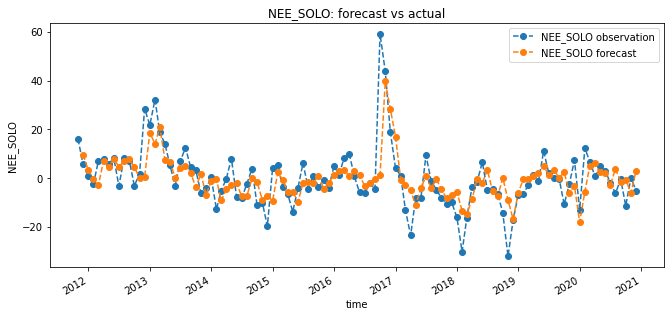

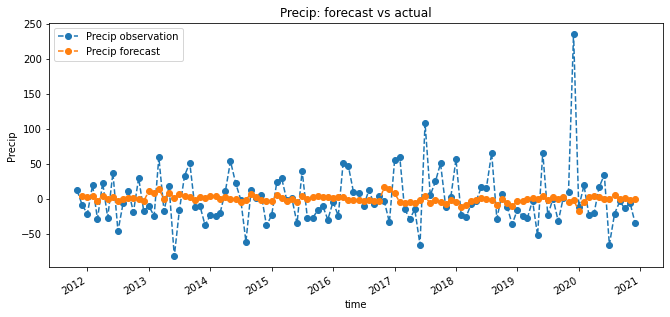

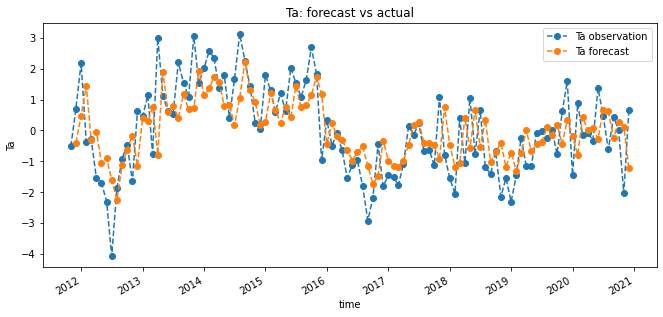

In [14]:
for col in df_in.columns:
    plt.figure(figsize=(11,5))
    plt.plot(df_in.index, df_in[col], label=col+' observation',linestyle='dashed', marker='o')
    fc[col].plot(label=col+' forecast',linestyle='dashed', marker='o')
    plt.ylabel(col)
    plt.title(col+": forecast vs actual")
    plt.legend();

### Make a forecast

In [15]:
model = VAR(endog=df_in,freq='MS')
model_fit = model.fit(lag_order)

pred = model_fit.forecast(df_in.values[-model_fit.k_ar:], steps=forecast_length)

In [16]:
#converting predictions to dataframe
cols = df_in.columns
fc = pd.DataFrame(index=range(0,len(pred)), columns=[cols])
for j in range(0,len(cols)):
    for i in range(0, len(pred)):
        fc.iloc[i][j] = pred[i][j]

fc.index = pd.date_range(freq='MS', start=df_in.index[-1], periods=len(fc)+1)[1:]
fc.head()

,NEE_SOLO,Precip,Ta
2021-01-01 00:30:00,-1.213465,1.886599,0.587834


### Plot the result of our forecast

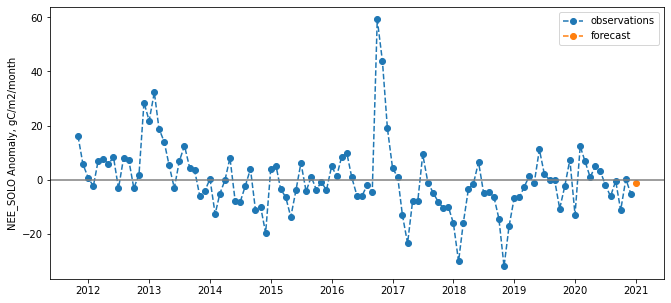

In [17]:
plt.figure(figsize=(11,5))
plt.plot(df_in.index, df_in[pred_var], label='observations',linestyle='dashed', marker='o')
plt.plot(fc.index, fc[[pred_var]], label='forecast',linestyle='dashed', marker='o')
plt.ylabel(pred_var+' Anomaly, gC/m2/month')
plt.axhline(0, color='grey')
# plt.title("NDVI Forecast")
# plt.ylim(0.0,0.9)
plt.legend();

## Multivariate forecasting with DARTS

Using the N-BEATS model: Neural Basis Expansion Analysis Time Series Forecasting 

Paper: https://openreview.net/forum?id=r1ecqn4YwB

In [18]:
from darts.models import NBEATSModel
from darts import TimeSeries
# from darts.models.forecasting.gradient_boosted_model import LightGBMModel

In [19]:
series_gpp = TimeSeries.from_dataframe(df_in, value_cols=['NEE_SOLO'])

covariates = TimeSeries.from_dataframe(df_in, value_cols=df_in.columns[1])

for i in range(0, len(df_in.columns[2:])):
    series = TimeSeries.from_dataframe(df_in, value_cols=df_in.columns[2+i])
    covariates=covariates.stack(series)

In [20]:
model = NBEATSModel(input_chunk_length=12, 
                        output_chunk_length=6)

model.fit([series_gpp], past_covariates=covariates)

# lag = gpp_predictors[0][1]
# model_gbm = LightGBMModel(lags=[lag], lags_past_covariates=[lag])
# model_gbm.fit(series_gpp, past_covariates=series_precip)

2022-08-10 14:54:51 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 93 samples.
2022-08-10 14:54:52 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-08-10 14:54:52 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-08-10 14:54:52 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-08-10 14:54:52 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-08-10 14:54:52 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-08-10 14:54:52 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.3 M 
---

Training: 0it [00:00, ?it/s]

2022-08-10 14:56:33 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


### Iterative backtest

In [21]:
backtests = model.historical_forecasts(series_gpp, past_covariates=covariates,
                            start=.5, retrain=False,
                            forecast_horizon=3, verbose=False)

# backtests_bm = model_gbm.historical_forecasts(series_gpp, past_covariates=series_precip,
#                             start=.5, forecast_horizon=3, verbose=False)

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

Predicting: 3it [00:00, ?it/s]

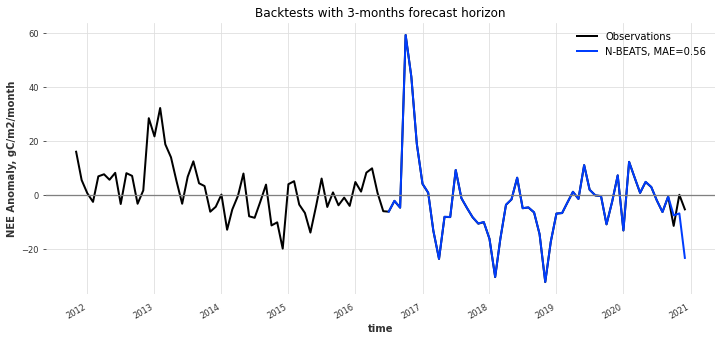

In [22]:
from darts.metrics import mape, mae

fig,ax = plt.subplots(figsize=(12,5))
series_gpp.plot(ax=ax,lw=2, label='Observations')
err = mae(backtests, series_gpp)
# err_bm = mae(backtests_bm, series_gpp)
# backtests_bm.plot(ax=ax, lw=2, label='{}, MAE={:.2f}'.format('GBM', err_bm))
backtests.plot(ax=ax, lw=2, label='{}, MAE={:.2f}'.format('N-BEATS', err))
plt.ylabel('NEE Anomaly, gC/m2/month')
plt.title('Backtests with 3-months forecast horizon')
plt.axhline(0, color='grey')
plt.legend()

### Forecast

In [23]:
pred = model.predict(n=3, series=series_gpp, past_covariates=covariates)

Predicting: 3it [00:00, ?it/s]

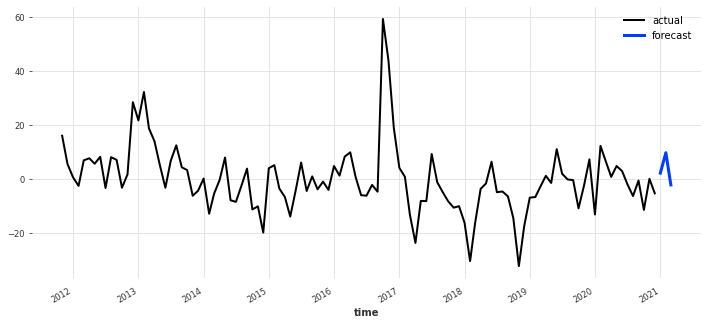

In [24]:
fig,ax = plt.subplots(figsize=(12,5))
series_gpp.plot(ax=ax, label='actual')
pred.plot(ax=ax, label='forecast', lw=3)
plt.legend()